error analysis

1. document length (word length)
2. token length (from tokenizer)
3. pos tag
4. syntactic analysis (liat pola ekstraksi)
5. menggunakan word2vec liat kata2nya dan cari pola kesamaannya (mengandung kata2 yang senada, liat cosine similaritynya)


In [2]:
import pandas as pd
from transformers import T5Tokenizer
import re
import nltk

/home/randy.suchrady/anaconda3/envs/absa/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
model_name_or_path = "/srv/nas_data1/text/randy/absa/models/facebook_research_10/generative/t5/t5_pabsa_S256_wid_small_blank=1.0"
not_pattern_char_regex = r"[^\(\),;]+"
regex_pattern = rf"\(\s?{not_pattern_char_regex}\s?,\s?{not_pattern_char_regex}\s?,\s?(positive|negative|neutral)\s?\)"
regex_pattern = re.compile(regex_pattern)

In [17]:
tokenizer = T5Tokenizer.from_pretrained(model_name_or_path)

In [58]:
news_prediction_path = "./news_test/aste/prediction.csv"
socmed_prediction_path = "./socmed_test/aste/prediction.csv"
train_path = "./train.csv"

news_pred = pd.read_csv(news_prediction_path)
socmed_pred = pd.read_csv(socmed_prediction_path)
train = pd.read_csv(train_path)

In [15]:
def count_input_token_length(row):
    text = row.text
    prompt = row.prompt

    inputs = prompt + " " + text

    return len(tokenizer.tokenize(inputs))

In [60]:
news_pred["n_token"] = news_pred.apply(count_input_token_length,axis=1)
socmed_pred["n_token"] = socmed_pred.apply(count_input_token_length,axis=1)
train["n_token"] = train.input.apply(lambda x : len(tokenizer.tokenize(x)))

In [21]:
def is_extract_format_true(x):
    if x.strip() == "NONE":
        return True
    splitted_x = x.split(';')
    splitted_x = [el.strip() for el in splitted_x]
    for el in splitted_x:
        if not bool(regex_pattern.match(el)):
            return False
    return True

In [22]:
news_pred["true_format"] = news_pred.string_preds.apply(is_extract_format_true)
socmed_pred["true_format"] = socmed_pred.string_preds.apply(is_extract_format_true)

In [31]:
def set_list_of_dict(l):
    result = [str(el) for el in l]
    result = list(set(result))
    result = [eval(el) for el in result]
    return result

def equal_pred_and_target(pred_,target_):
    pred = set_list_of_dict(eval(pred_))
    target = set_list_of_dict(eval(target_))

    if len(pred) != len(target):
        return False
    
    if len(pred) == 0:
        return True
    
    for p in pred:
        if p not in target:
            return False
    return True

In [36]:
false_news_condition = news_pred.apply(lambda x: not equal_pred_and_target(x.raw_prediction,x.target),axis=1)
false_socmed_condition = socmed_pred.apply(lambda x: not equal_pred_and_target(x.raw_prediction,x.target),axis=1)

In [37]:
false_news = news_pred.loc[false_news_condition]
false_socmed = socmed_pred.loc[false_socmed_condition]

# Token Length Analysis

## Test data

In [62]:
print(false_news.n_token.describe())

count    117.000000
mean      46.316239
std       36.267837
min       19.000000
25%       30.000000
50%       40.000000
75%       52.000000
max      359.000000
Name: n_token, dtype: float64


In [63]:
print(false_socmed.n_token.describe())

count    559.000000
mean      55.279070
std       20.565154
min       20.000000
25%       40.500000
50%       52.000000
75%       66.500000
max      184.000000
Name: n_token, dtype: float64


In [3]:
import matplotlib.pyplot as plt

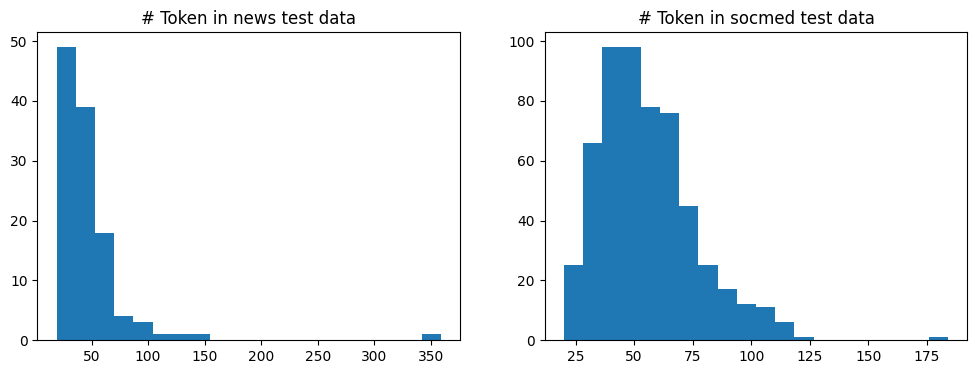

In [57]:
fig,ax = plt.subplots(1,2,figsize=(12, 4))

ax[0].hist(false_news.n_token,bins=20)
ax[0].set_title("# Token in news test data")

ax[1].hist(false_socmed.n_token,bins=20)
ax[1].set_title("# Token in socmed test data")

plt.show()

In [90]:
false_news_more_than_256 = false_news.loc[false_news.n_token > 256].shape[0]
false_socmed_more_than_256 = false_socmed.loc[false_socmed.n_token > 256].shape[0]

In [91]:
print(false_news_more_than_256)

1


In [93]:
print(false_socmed_more_than_256)

0


## Training data

In [64]:
aste_train = train.loc[train.task == "aste"]

print(aste_train.n_token.describe())

count    14473.000000
mean        41.889657
std         33.689298
min          9.000000
25%         25.000000
50%         35.000000
75%         52.000000
max       1351.000000
Name: n_token, dtype: float64


In [77]:
len(nltk.tokenize.sent_tokenize(aste_train.loc[aste_train.n_token == 1351].text.iloc[0]))

28

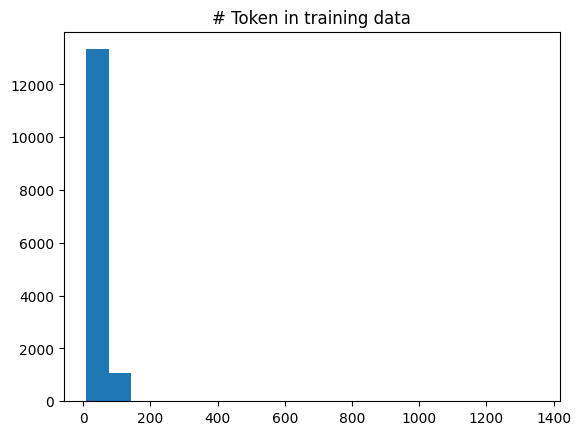

In [65]:
plt.hist(aste_train.n_token,bins=20)
plt.title("# Token in training data")
plt.show()

In [94]:
train_more_than_256 = train.loc[train.n_token > 256].shape[0]

In [95]:
print(train_more_than_256)

142


# OOV

In [107]:
tokenizer.convert_tokens_to_string(tokenizer.tokenize("aku suka kamu"))

'aku suka kamu'

In [109]:
def is_tokenized_well(text):
    text1 = text.replace(" ","")
    text2 = tokenizer.convert_tokens_to_string(tokenizer.tokenize(text)).replace(" ","")
    return text1 == text2

In [118]:
false_news["is_tokenized_well"] = false_news.text.apply(is_tokenized_well)
false_socmed["is_tokenized_well"] = false_socmed.text.apply(is_tokenized_well)
train["is_tokenized_well"] = train.text.apply(is_tokenized_well)

/tmp/ipykernel_38373/3338247691.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_news["is_tokenized_well"] = false_news.text.apply(is_tokenized_well)


In [115]:
false_news.loc[~false_news.is_tokenized_well]

,text,prompt,target,raw_prediction,editdistance_prediction,cut_predictions,remove_predictions,string_preds,n_token,true_format,pos_tag,is_tokenized_well


In [116]:
false_socmed.loc[~false_socmed.is_tokenized_well]

,text,prompt,target,raw_prediction,editdistance_prediction,cut_predictions,remove_predictions,string_preds,n_token,true_format,pos_tag,is_tokenized_well


In [119]:
train.loc[~train.is_tokenized_well]

,text,target,num_target,task,input,prompt,n_token,is_tokenized_well


# Extraction Format Analysis

In [81]:
false_news_false_format = false_news.loc[~false_news.true_format]
false_socmed_false_format = false_socmed.loc[~false_socmed.true_format]

In [88]:
for el in false_news_false_format["text"]:
    print(el)
    print()

" Ada enggak seneng nya karena kita bakal ada yang macet , yang tadi saya bilang ada demo gitu-gitu , " ujar Syifa seperti dikutip YouTube Sekretariat Presiden , Sabtu ( 19 / 3 ) .

Ia mengaku hati nya terasa berat ketika melihat fan atau ARMY tidak bisa ikut bersorak , tepuk tangan , dan berdiri selama konser .



In [86]:
for el in false_news_false_format["string_preds"]:
    print(el)
    print()

( ada enggak seneng, negative ) ; ( ada, macet, negative ) ; ( demo, ada, negative )

( hati nya terasa berat, negative ) ; ( ARMY, tidak bisa ikut bersorak, negative )



In [89]:
for el in false_socmed_false_format["text"]:
    print(el)
    print()

Sementara jutaan anak Indonesia lain , berbulan-bulan cuma bengong selama pembelajaran jarak jauh . Orangtua kurang educated , ga bisa ngajarin di rumah . Sekolah memberi tugas tanpa penjelasan . Beruntung anak-anak yang punya previledge orangtua berpendidikan dan berpengalaman .

Blibli pengiriman barang nya tepat waktu dan customer care nya tanggap banget . Kemarin saya beli barang dan gak nyampe-nyampe langsung hubungi customer care dan ditangani dengan baik . Mantap

Senang belanja di sini sebab ada potongan ongkos kirim bahkan gratis pake instan ataupun sameday . . . aplikasi yang bagus pertahankan gratis ongkir nya yaa blibli . . .

Aplikasi sangat bagus , terutama di masa pandemi ini untuk menghindari kontak langsung dan penggunaan uang tunai . Namun sangat disayangkan sekali banyak kendala2 yg dirasakan oleh pengguna salah satu nya saya sendiri saat akan menggunakan aplikasi ini , tidak semua spbu sudah ada aplikasi ini , klopun ada rata2 pada jawab gak bisa krn jaringan lama ,

In [87]:
for el in false_socmed_false_format["string_preds"]:
    print(el)
    print()

( Orangtua, kurang educated, negative ) ; ( Orangtua, ga bisa ngajarin di rumah, negative ) ; ( orangtua, berpendidikan, positive ) ; ( orangtua, berpengalaman, positive ) ; ( ngajarin di rumah, ga bisa ngajarin di rumah, negative ) ; ( ngajarin di rumah, ga bisa ngajarin di rumah, negative ) ; ( ngajarin di rumah, negative ) ; ( orangtua, berpendidikan, positive ) ; ( orangtua, punya previledge, positive )

( pengiriman barang, tepat waktu, positive ) ; ( pengiriman barang, tanggap banget, positive ) ; ( customer care, tanggap banget, positive ) ; ( hubungi, langsung hubungi customer care, positive ) ; ( ditangani, baik, positive ) ; ( Mantap, positive )

( belanja, Senang, positive ) ; ( potongan ongkos kirim, ada, positive ) ; ( gratis, positive ) ; ( aplikasi, bagus, positive )

( Aplikasi, sangat bagus, positive ) ; ( Aplikasi, sangat disayangkan sekali, negative ) ; ( Aplikasi, banyak kendala2, negative ) ; ( aplikasi, simple, positive ) ; ( aplikasi, cepat, positive ) ; ( jawab,

# Syntactic Analysis Conclusion

1. Perlu direview apakah data latih dan data uji perlu difilter menjadi < 256 token, apakah harus dilakukan sentence splitting, perhatikan nanti apakah ada aspek-opini yang bersebrangan (kalimatnya)
2. tidak ada oov, karena tokenizernya bisa melakukan tokenisasi pada tingkat alfabet dan subphrase
3. Untuk format ekstraksi, terdapat beberapa pengulangan tuple yang valuenya sama. Untuk tuple yang formatnya tidak sesuai, ada beberapa kemungkinan:
    - Aspek implisit (seperti di paper william fu)
    - Hanya penanda opini saja yang diekstrak
    - Sebenarnya aspek ada di dalam penanda opini (contoh : 'bayar pake tunai' --> aspeknya : bayar | opini : pake tunai)

# POS tag analysis

In [4]:
from transformers import pipeline

In [96]:
postagger_src = "w11wo/indonesian-roberta-base-posp-tagger"

hf_postagger_model = pipeline("token-classification",model=postagger_src)

Downloading: 100%|██████████| 1.67k/1.67k [00:00<00:00, 1.37MB/s]
Downloading: 100%|██████████| 496M/496M [01:37<00:00, 5.11MB/s]   
Downloading: 100%|██████████| 327/327 [00:00<00:00, 130kB/s]
Downloading: 100%|██████████| 808k/808k [00:01<00:00, 458kB/s]  
Downloading: 100%|██████████| 467k/467k [00:04<00:00, 105kB/s]  
Downloading: 100%|██████████| 1.38M/1.38M [00:08<00:00, 164kB/s] 
Downloading: 100%|██████████| 239/239 [00:00<00:00, 157kB/s]


In [101]:
false_news["pos_tag"] = false_news.text.apply(hf_postagger_model)
false_socmed["pos_tag"] = false_socmed.text.apply(hf_postagger_model)

/tmp/ipykernel_38373/144800647.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_news["pos_tag"] = false_news.text.apply(hf_postagger_model)


In [120]:
false_news.to_csv("./cp/false_news.csv",index=False)
false_socmed.to_csv("./cp/false_socmed.csv",index=False)
train.to_csv("./cp/train.csv",index=False)

In [9]:
false_news = pd.read_csv("./cp/false_news.csv")
false_socmed = pd.read_csv("./cp/false_socmed.csv")
train = pd.read_csv("./cp/train.csv")

# Error Type

In [9]:
def error_type(row):
    target = eval(row.target)
    raw_prediction = eval(row.raw_prediction)

    if len(target) == 0:
        return 1
    if len(raw_prediction) == 0:
        return 2
    return 3

In [10]:
false_news["error_type"] = false_news.apply(error_type,axis=1)
false_socmed["error_type"] = false_socmed.apply(error_type,axis=1)

In [13]:
print(false_news.error_type.value_counts())
print(false_socmed.error_type.value_counts())

3    55
1    43
2    19
Name: error_type, dtype: int64
3    463
1     70
2     26
Name: error_type, dtype: int64


Urutan tipe error dari yang terbanyak adalah sebagai berikut:
1. error tipe 3 : target dan prediksi tidak kosong
2. error tipe 1 : hanya target yang kosong (over extract)
3. error tipe 2 : hanya prediksi yang kosong (under extract)

In [15]:
sample_false_news = pd.concat([
    false_news.loc[false_news.error_type == 1].sample(5,random_state=42),
    false_news.loc[false_news.error_type == 2].sample(5,random_state=42),
    false_news.loc[false_news.error_type == 3].sample(5,random_state=42)
])

sample_false_socmed = pd.concat([
    false_socmed.loc[false_socmed.error_type == 1].sample(5,random_state=42),
    false_socmed.loc[false_socmed.error_type == 2].sample(5,random_state=42),
    false_socmed.loc[false_socmed.error_type == 3].sample(5,random_state=42)
])

In [16]:
sample_false_news

,text,prompt,target,raw_prediction,editdistance_prediction,cut_predictions,remove_predictions,string_preds,n_token,true_format,pos_tag,is_tokenized_well,error_type
104,""" Apabila salah satu izin nya tak keluar , mak...",ekstraksi triplet aste :,[],"[{'aspect': 'izin', 'opinion': 'tidak keluar',...","[{'aspect': 'izin', 'opinion': 'tak keluar', '...","[{'aspect': 'izin', 'opinion': 'tak keluar', '...","[{'aspect': 'izin', 'opinion': 'tak keluar', '...","( izin, tidak keluar, negative ) ; ( konser, t...",48,True,"[{'entity': 'B-SYM', 'score': 0.9997551, 'inde...",True,1
65,""" SE ini berlaku sejak tanggal ditetapkan dan ...",ekstraksi triplet aste :,[],"[{'aspect': 'SE No. 3 / 2022', 'opinion': 'dic...","[{'aspect': 'SE No. 3 / 2022', 'opinion': 'dic...","[{'aspect': 'SE No. 3 / 2022', 'opinion': 'dic...","[{'aspect': 'SE No. 3 / 2022', 'opinion': 'dic...","( SE No. 3 / 2022, dicabut, negative ) ; ( SE ...",61,True,"[{'entity': 'B-SYM', 'score': 0.9995946, 'inde...",True,1
66,Luhut termasuk yang setuju segera pembangunan ...,ekstraksi triplet aste :,[],"[{'aspect': 'Luhut', 'opinion': 'setuju segera...","[{'aspect': 'Luhut', 'opinion': 'setuju segera...","[{'aspect': 'Luhut', 'opinion': 'setuju segera...","[{'aspect': 'Luhut', 'opinion': 'setuju segera...","( Luhut, setuju segera pembangunan proyek, pos...",19,True,"[{'entity': 'B-NNO', 'score': 0.7169634, 'inde...",True,1
103,"Menurut nya , tak ada hal yang perlu dikhawati...",ekstraksi triplet aste :,[],"[{'aspect': 'hal', 'opinion': 'tak ada', 'sent...","[{'aspect': 'hal', 'opinion': 'tak ada', 'sent...","[{'aspect': 'hal', 'opinion': 'tak ada', 'sent...","[{'aspect': 'hal', 'opinion': 'tak ada', 'sent...","( hal, tak ada, positive )",24,True,"[{'entity': 'B-PPO', 'score': 0.8756924, 'inde...",True,1
98,"Kanye menikah dengan Kim Kardashian , sosialit...",ekstraksi triplet aste :,[],"[{'aspect': 'konser musik', 'opinion': 'sudah ...","[{'aspect': 'konser musik', 'opinion': 'sudah ...","[{'aspect': 'konser musik', 'opinion': 'sudah ...","[{'aspect': 'konser musik', 'opinion': 'sudah ...","( konser musik, sudah bisa dijalankan, positive )",48,True,"[{'entity': 'B-NNP', 'score': 0.94476414, 'ind...",True,1
3,""" Komisi menganggap ada peran gas alam dan nuk...",ekstraksi triplet aste :,"[{'aspect': 'gas alam dan nuklir', 'opinion': ...",[],[],[],[],NONE,54,True,"[{'entity': 'B-SYM', 'score': 0.9997681, 'inde...",True,2
19,Alhasil pelaku usaha pun bisa mengukur berapa ...,ekstraksi triplet aste :,"[{'aspect': 'pelaku usaha', 'opinion': 'bisa m...",[],[],[],[],NONE,22,True,"[{'entity': 'B-NNO', 'score': 0.55355394, 'ind...",True,2
63,Mulai dari penonton yang berdesakkan hingga ba...,ekstraksi triplet aste :,"[{'aspect': 'penonton', 'opinion': 'berdesakka...",[],[],[],[],NONE,28,True,"[{'entity': 'B-VBI', 'score': 0.95604974, 'ind...",True,2
6,"Mereka menampilkan pesan "" Matilah Imperialis ...",ekstraksi triplet aste :,"[{'aspect': 'pesan', 'opinion': 'Matilah', 'se...",[],[],[],[],NONE,21,True,"[{'entity': 'B-PRN', 'score': 0.99491274, 'ind...",True,2
37,Masalah nya ketergantungan Eropa terhadap paso...,ekstraksi triplet aste :,"[{'aspect': 'ketergantungan Eropa', 'opinion':...",[],[],[],[],NONE,22,True,"[{'entity': 'B-NNO', 'score': 0.99684876, 'ind...",True,2


In [18]:
sample_false_news.to_csv("./cp/sample_false_news.csv",index=False)
sample_false_socmed.to_csv("./cp/sample_false_socmed.csv",index=False)

In [5]:
sample_false_news = pd.read_csv("./cp/sample_false_news.csv")
sample_false_socmed = pd.read_csv("./cp/sample_false_socmed.csv")

In [15]:
fixed_prediction_news = false_news.loc[false_news.raw_prediction != false_news.editdistance_prediction].copy()
fixed_prediction_socmed = false_socmed.loc[false_socmed.raw_prediction != false_socmed.editdistance_prediction].copy()

In [24]:
fixed_prediction_news = fixed_prediction_news[["text","raw_prediction","editdistance_prediction"]]
fixed_prediction_socmed = fixed_prediction_socmed[["text","raw_prediction","editdistance_prediction"]]

In [40]:
fixed_prediction_news.loc[42,"editdistance_prediction"]

"[{'aspect': 'pt pln ( persero )', 'opinion': 'sempat mengalami krisis gas alam cair ( liquefied natural gas / lng )', 'sentiment': 'negative'}]"